In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader
import os
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import convnext_tiny
from torch.optim.lr_scheduler import StepLR

In [28]:
def set_seed(seed=777):
    """Устанавливает фиксированный сид для воспроизводимости."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)           # для одного GPU
    torch.cuda.manual_seed_all(seed)       # если несколько GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(7777)

In [29]:
# Пути к данным (Kaggle)
TOMATO_ROOT = "/kaggle/input/tomato-diseases/tomato_disease"
CUCUMBER_ROOT = "/kaggle/input/cucumbers-diseases/cucumbers"

In [68]:
# Аугментация для тренировочных данных
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Только нормализация для валидации/теста
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [78]:
# Загружаем только здоровые и больные листья — но нам нужна только принадлежность к виду
# Поэтому используем ImageFolder, но потом заменим метки на "tomato"=0, "cucumber"=1

class SpeciesDataset(datasets.ImageFolder):
    def __init__(self, root, species_label, transform=None):
        super().__init__(root, transform=transform)
        self.species_label = species_label  # 0 или 1

    def __getitem__(self, idx):
        img, _ = super().__getitem__(idx)  # игнорируем оригинальный класс болезни
        return img, self.species_label

class_names = ["tomato", "cucumber"]

In [70]:
# Тренировочные данные
tomato_train = SpeciesDataset(
    root=os.path.join(TOMATO_ROOT, "train"),
    species_label=0,  # tomato
    transform=train_transform
)

cucumber_train = SpeciesDataset(
    root=os.path.join(CUCUMBER_ROOT, "train"),
    species_label=1,  # cucumber
    transform=train_transform
)

# Объединяем
train_dataset = ConcatDataset([tomato_train, cucumber_train])

# Аналогично для валидации
tomato_val = SpeciesDataset(
    root=os.path.join(TOMATO_ROOT, "test"),  # обычно test = val
    species_label=0,
    transform=val_transform
)

cucumber_val = SpeciesDataset(
    root=os.path.join(CUCUMBER_ROOT, "test"),
    species_label=1,
    transform=val_transform
)

val_dataset = ConcatDataset([tomato_val, cucumber_val])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Train samples: 1704, Val samples: 450


In [71]:
model = convnext_tiny(weights="DEFAULT")
model.classifier[2] = torch.nn.Linear(768, 2)  # Заменяем последний слой
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [72]:
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-5},     # backbone
    {'params': model.classifier.parameters(), 'lr': 5e-4}     # head
], weight_decay=1e-3)

# Снижение LR каждые 5 эпох
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Лосс с label smoothing — уменьшает переобучение
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [73]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    os.makedirs('/kaggle/working/models', exist_ok=True)
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_epoch = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            
            # Для прогресс-бара показываем текущую статистику по эпохе
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            loop.set_postfix({
                'loss': f"{running_loss / train_total:.4f}", 
                'acc': f"{100 * train_correct / train_total:.2f}%"
            })

        # Перевычисляем train accuracy в eval режиме в конце эпохи
        model.eval()
        final_train_correct = 0
        final_train_total = 0
        final_train_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                final_train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                final_train_total += labels.size(0)
                final_train_correct += (predicted == labels).sum().item()
        
        # Validation
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Финальные метрики
        avg_train_loss = final_train_loss / final_train_total
        avg_val_loss = val_loss / val_total
        train_acc = 100 * final_train_correct / final_train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Сохранение лучшей модели (по точности)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_val_loss = avg_val_loss
            
            torch.save(model.state_dict(), '/kaggle/working/models/best_model.pth')
        
        model.train()

        #scheduler.step()
    
    # Загрузка лучшей модели в конце
    try:
        model.load_state_dict(torch.load('/kaggle/working/models/best_model.pth'))
        print(f"\nЗагружена лучшая модель с {best_epoch} эпохи")
        print(f"Лучшая Val Accuracy: {best_val_acc:.2f}%")
    except Exception as e:
        print("Ошибка при загрузке модели:", e)
        
    return model, train_losses, val_losses, train_accs, val_accs, best_epoch

In [74]:
model, train_losses, val_losses, train_accs, val_accs, best_epoch = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1/10: 100%|██████████| 54/54 [01:17<00:00,  1.43s/it, loss=0.4527, acc=84.74%]


Train Loss: 0.3068, Train Acc: 94.42%
Val Loss: 0.2929, Val Acc: 94.89%


Epoch 2/10: 100%|██████████| 54/54 [01:17<00:00,  1.43s/it, loss=0.2895, acc=95.25%]


Train Loss: 0.2651, Train Acc: 97.07%
Val Loss: 0.2683, Val Acc: 97.33%


Epoch 3/10: 100%|██████████| 54/54 [01:16<00:00,  1.42s/it, loss=0.2618, acc=97.18%]


Train Loss: 0.2430, Train Acc: 98.94%
Val Loss: 0.2479, Val Acc: 98.89%


Epoch 4/10: 100%|██████████| 54/54 [01:17<00:00,  1.43s/it, loss=0.2479, acc=98.24%]


Train Loss: 0.2341, Train Acc: 98.88%
Val Loss: 0.2422, Val Acc: 98.67%


Epoch 5/10: 100%|██████████| 54/54 [01:16<00:00,  1.42s/it, loss=0.2406, acc=98.42%]


Train Loss: 0.2272, Train Acc: 99.24%
Val Loss: 0.2368, Val Acc: 99.11%


Epoch 6/10: 100%|██████████| 54/54 [01:18<00:00,  1.44s/it, loss=0.2284, acc=99.30%]


Train Loss: 0.2224, Train Acc: 99.53%
Val Loss: 0.2308, Val Acc: 99.33%


Epoch 7/10: 100%|██████████| 54/54 [01:16<00:00,  1.42s/it, loss=0.2252, acc=99.41%]


Train Loss: 0.2198, Train Acc: 99.71%
Val Loss: 0.2321, Val Acc: 99.11%


Epoch 8/10: 100%|██████████| 54/54 [01:16<00:00,  1.42s/it, loss=0.2221, acc=99.53%] 


Train Loss: 0.2152, Train Acc: 99.77%
Val Loss: 0.2288, Val Acc: 98.89%


Epoch 9/10: 100%|██████████| 54/54 [01:17<00:00,  1.44s/it, loss=0.2190, acc=99.41%]


Train Loss: 0.2125, Train Acc: 99.88%
Val Loss: 0.2277, Val Acc: 99.11%


Epoch 10/10: 100%|██████████| 54/54 [01:17<00:00,  1.43s/it, loss=0.2158, acc=99.65%]


Train Loss: 0.2098, Train Acc: 99.82%
Val Loss: 0.2245, Val Acc: 99.11%

Загружена лучшая модель с 6 эпохи
Лучшая Val Accuracy: 99.33%


In [75]:
def plot_loss_acc(train_losses, val_losses, train_accs, val_accs, best_epoch):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 8))
    
    # График лоссов
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=1, label=f'Best epoch ({best_epoch})')  # <<< Линия
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # График accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Val Accuracy')
    plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=1, label=f'Best epoch ({best_epoch})')  # <<< Линия
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics.png')
    plt.show()

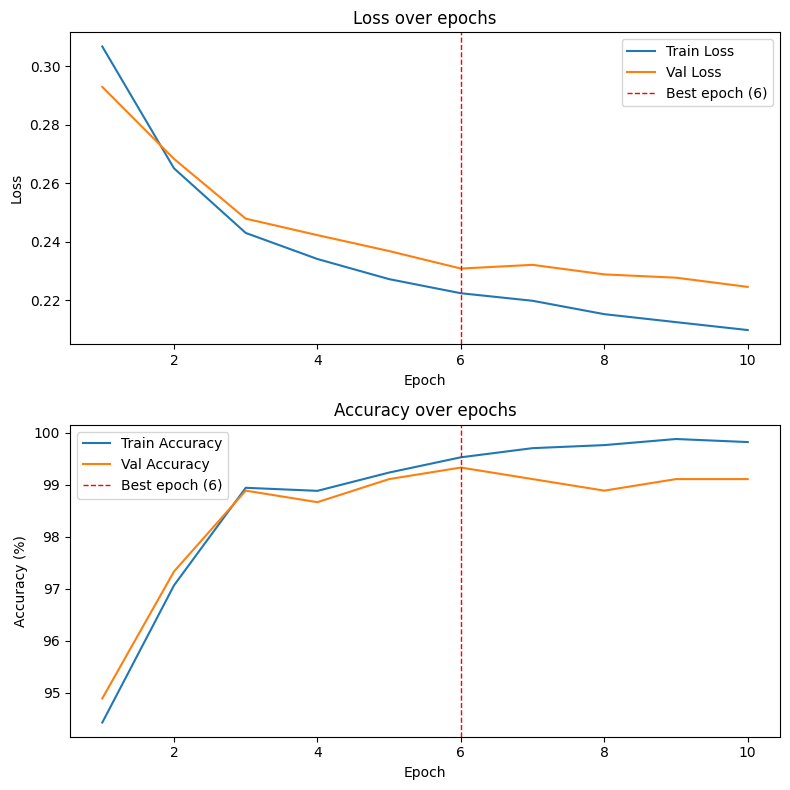

In [76]:
plot_loss_acc(train_losses, val_losses, train_accs, val_accs, best_epoch)

In [79]:
# Вспомогательная функция
def evaluate_confusion(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Получаем предсказания для валидационного набора
true_labels, pred_labels = evaluate_confusion(model, val_loader, class_names)

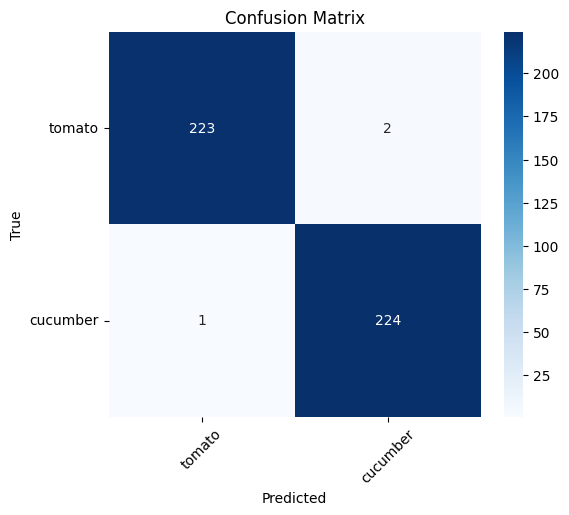

In [81]:
# Матрица ошибок
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(true_labels, pred_labels, class_names)

In [84]:
def visualize_val_errors(model, val_loader, val_dataset, class_names, device, figsize=(15, 6)):
    """
    Прогоняет модель по val-выборке и визуализирует ошибки.
    
    Аргументы:
    - model: обученная модель (в eval-режиме)
    - val_loader: DataLoader для валидации
    - val_dataset: оригинальный ConcatDataset (с tomato_val + cucumber_val)
    - class_names: список имён классов, например ['tomato', 'cucumber']
    - device: 'cuda' или 'cpu'
    - figsize: размер фигуры для отображения
    """
    model.eval()
    error_paths = []  # Будем хранить (путь, true_label, pred_label, confidence)
    
    # Функция получения пути по индексу в ConcatDataset
    def get_path_by_idx(dataset, idx):
        if idx < len(dataset.datasets[0]):
            inner_dataset = dataset.datasets[0]  # tomato_val
            inner_idx = idx
        else:
            inner_dataset = dataset.datasets[1]  # cucumber_val
            inner_idx = idx - len(dataset.datasets[0])
        return inner_dataset.samples[inner_idx][0]  # путь к файлу

    with torch.no_grad():
        running_idx = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, dim=1)
            
            # Проверяем ошибки в батче
            for i in range(inputs.size(0)):
                global_idx = running_idx + i
                if global_idx >= len(val_dataset):
                    break
                if preds[i].item() != labels[i].item():
                    path = get_path_by_idx(val_dataset, global_idx)
                    true_label = labels[i].item()
                    pred_label = preds[i].item()
                    confidence = probs[i].max().item()
                    error_paths.append((path, true_label, pred_label, confidence))
            running_idx += inputs.size(0)

    # Выводим результаты
    num_errors = len(error_paths)
    print(f"🔍 Найдено ошибок на val-выборке: {num_errors}")

    if num_errors == 0:
        print("🎉 Модель не совершила ни одной ошибки!")
        return

    # Визуализация
    cols = num_errors
    plt.figure(figsize=(4 * cols, 4))
    
    for idx, (path, true_label, pred_label, confidence) in enumerate(error_paths):
        image = Image.open(path).convert("RGB")
        
        plt.subplot(1, cols, idx + 1)
        plt.imshow(image)
        plt.title(
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[pred_label]}\n"
            f"Conf: {confidence:.3f}",
            fontsize=10
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

🔍 Найдено ошибок на val-выборке: 3


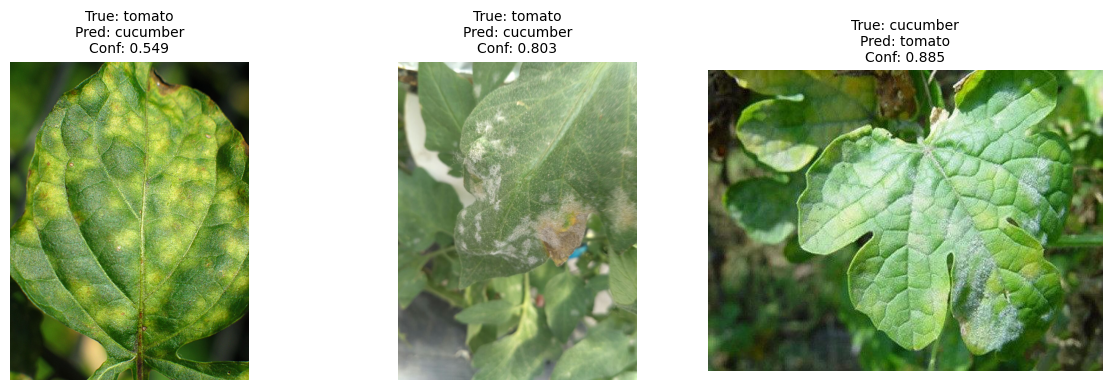

In [85]:
# Запуск функции
visualize_val_errors(
    model=model,
    val_loader=val_loader,
    val_dataset=val_dataset,
    class_names=class_names,
    device=device
)